In [74]:
# Imports
import pandas as pd
import spacy
import re
import torch
from transformers import GPT2Tokenizer, GPT2Model, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/LLM_thesis/filtered_df.parquet'
filtered_df = pd.read_parquet(file_path)

#### Embedding Analysis for GPT-2 (baseline)

#### Creating a balanced subset for embedding analysis

In [6]:
# Takes a subset of 5 sentences that contain gendered terms per category to ensure a balanced representation
balanced_sample = []

for cat in sorted(filtered_df["stereotype"].unique()):
    group = filtered_df[filtered_df["stereotype"] == cat]

    # Filters for gendered terms
    gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]

    if len(gendered) >= 5:
        sample = gendered.sample(n=5, random_state=42)
        balanced_sample.append(sample)
    else:
        print(f"⚠️ Not enough gendered examples in category {cat}: only {len(gendered)} found")

final_subset_df = pd.concat(balanced_sample).reset_index(drop=True)
print(f"Final balanced subset: {len(final_subset_df)} sentences")

Final balanced subset: 80 sentences


<ipython-input-6-b59fdc4ed290>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]


In [25]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_gender_and_closest_token(text):
    doc = nlp(text)
    # Sampe pronouns/gendered terms used previously
    gender_terms = {"he", "she", "his", "her", "man", "woman", "boy", "girl", "women", "men"}
    gender_idxs = [i for i, token in enumerate(doc) if token.text.lower() in gender_terms]

    if not gender_idxs:
        return pd.Series([None, None])

    # Uses the first gendered term for simplicity
    gender_idx = gender_idxs[0]
    gender_term = doc[gender_idx].text

    # Candidates: nouns and adjectives
    candidates = [(i, token.text, token.pos_) for i, token in enumerate(doc) if
                  token.pos_ in {"NOUN", "ADJ"} and token.text.lower() not in
                  gender_terms]

    if not candidates:
        return pd.Series([gender_term, None])

    # Closest token by distance to gendered pronoun -> might change later
    closest = min(candidates, key=lambda x: abs(x[0] - gender_idx))
    closest_token = closest[1]

    return pd.Series([gender_term, closest_token])

In [26]:
final_subset_df[["pronoun", "relevant_token"]] = final_subset_df["sentence"].apply(extract_gender_and_closest_token)

In [35]:
# final_subset_df.head(50)
# Took a look at the selection and it looks pretty good. I do think it can be improved, so later on might try to select it based on sentiment.
# I thought manual selection might be too time consuming and also introduces my own biases so for now it's automated.

#### Compute cosine similarity at the token level for gendered term & adj/noun for GPT-2

Sources:
- https://huggingface.co/docs/transformers/main_classes/tokenizer
- https://medium.com/@khiljidanial/cosine-similarity-using-gpt-models-35b6b9685d70

In [36]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
model = GPT2Model.from_pretrained("openai-community/gpt2")

In [45]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [56]:
def get_token_embedding(text, target_token):
    if not target_token:  # handles None, empty strings..
        return None

    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

    # Match by substring ignoring case
    match_indices = [i for i, tok in enumerate(tokens) if target_token.lower() in tok.lower()]
    if not match_indices:
        return None

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state.squeeze(0)

    return last_hidden_state[match_indices[0]].cpu().numpy()

In [57]:
# Function to compute cosine similarity
def compute_cosine(row):
    sentence = row["sentence"]
    pronoun = row["pronoun"]
    token = row["relevant_token"]

    emb_pronoun = get_token_embedding(sentence, pronoun)
    emb_token = get_token_embedding(sentence, token)
    if emb_pronoun is None or emb_token is None:
        return 0.0

    return cosine_similarity([emb_pronoun], [emb_token])[0][0]

In [80]:
final_subset_df["cosine_similarity"] = final_subset_df.apply(compute_cosine, axis=1)

In [71]:
# For each stereotype category(16) show the pronoun and relevant token with highest and lowest cosine similarities
# Groups data by stereotype category
grouped = final_subset_df.groupby("stereotype")

# Iterates through each stereotype category
for stereotype, group_df in grouped:
    # Finds the highest and lowest cosine similarity for each category
    highest_similarity_row = group_df.loc[group_df['cosine_similarity'].idxmax()]
    lowest_similarity_row = group_df.loc[group_df['cosine_similarity'].idxmin()]

    print(f"Stereotype: {stereotype}")
    print(f"  Highest Cosine Similarity:")
    print(f"    Pronoun: {highest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {highest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {highest_similarity_row['cosine_similarity']:.2f}")
    print(f"  Lowest Cosine Similarity:")
    print(f"    Pronoun: {lowest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {lowest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {lowest_similarity_row['cosine_similarity']:.2f}")
    print("-" * 20)

Stereotype: 1
  Highest Cosine Similarity:
    Pronoun: She
    Relevant Token: day
    Cosine Similarity: 0.98
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: fights
    Cosine Similarity: 0.95
--------------------
Stereotype: 2
  Highest Cosine Similarity:
    Pronoun: her
    Relevant Token: food
    Cosine Similarity: 0.99
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: housewife
    Cosine Similarity: 0.00
--------------------
Stereotype: 3
  Highest Cosine Similarity:
    Pronoun: She
    Relevant Token: sons
    Cosine Similarity: 0.98
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: kind
    Cosine Similarity: 0.94
--------------------
Stereotype: 4
  Highest Cosine Similarity:
    Pronoun: she
    Relevant Token: neighbour
    Cosine Similarity: 0.99
  Lowest Cosine Similarity:
    Pronoun: her
    Relevant Token: greasy
    Cosine Similarity: 0.00
--------------------
Stereotype: 5
  Highest Cosine Similarity:
    Pronoun: he


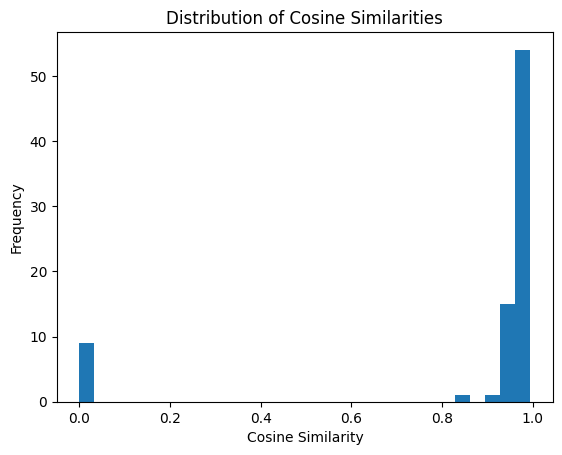

In [73]:
plt.hist(final_subset_df['cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()